In [71]:
# Import standard libraries
import os
from collections import Counter


# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [72]:
# Load the level 2 asteroid data
core_path = "../asteroid_taxonomy"
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [73]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

In [74]:
print(f"Max: {np.max(asteroids_X)}")
print(f"Min: {np.min(asteroids_X)}")


Max: 1.4405
Min: 0.6089


In [75]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [76]:
asteroids_x_bins = np.arange(0.60, 1.1, 0.1)

In [77]:
y_train

array(['Other', 'S', 'S', ..., 'C', 'S', 'C'], dtype='<U5')

Text(0.5, -0.08, 'Split proportions')

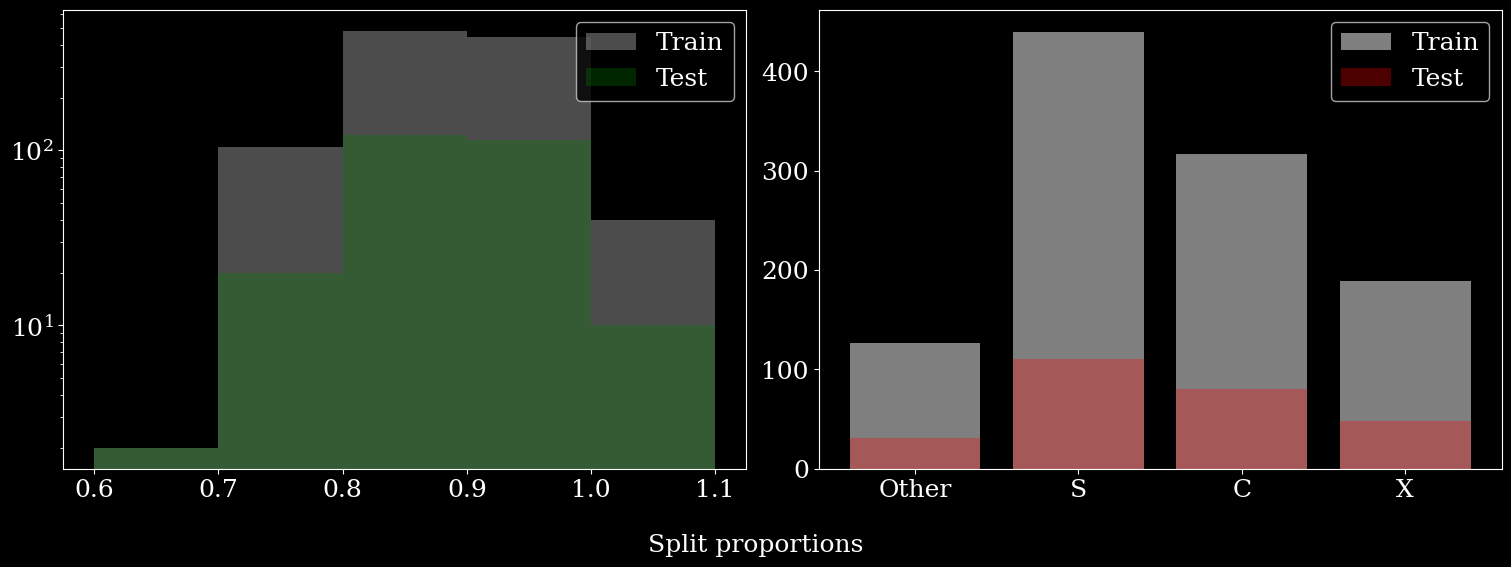

In [78]:
# after spliting unweighted distribution histogram plots

fig, (ax1, ax2) = plt.subplots(1,2,
                                    layout="constrained",
                                    sharey=False,
                                    figsize=(15,5))

ax1.hist(X_train[:, 1], bins=asteroids_x_bins, alpha=0.3, color="white", label="Train")
ax1.hist(X_test[:, 1], bins=asteroids_x_bins, alpha=0.3, color="green", label="Test")
ax1.set_yscale("log")

ax1.legend(loc="upper right")

# count bar
counts_train = Counter(y_train)
counts_test = Counter(y_test)
labels_train, values_train = zip(*counts_train.items())
labels_test, values_test = zip(*counts_test.items())

ax2.bar(labels_train, values_train, alpha=0.5, color="white", label="Train")
ax2.bar(labels_test, values_test, alpha=0.3, color="red", label="Test")

ax2.legend(loc="upper right")

fig.text(0.5, -0.08, "Split proportions", ha='center', va='center')

In [79]:
X_train

array([[0.7096, 0.7353, 0.7611, ..., 1.1745, 1.1742, 1.1731],
       [0.8606, 0.8743, 0.8881, ..., 1.0698, 1.0752, 1.082 ],
       [0.8188, 0.8405, 0.8609, ..., 1.0099, 1.0045, 1.002 ],
       ...,
       [0.9454, 0.9523, 0.9592, ..., 0.9695, 0.9673, 0.9654],
       [0.846 , 0.8631, 0.8801, ..., 0.9612, 0.9608, 0.9624],
       [0.9166, 0.9251, 0.9338, ..., 0.983 , 0.9802, 0.9784]])

In [80]:
# standardscaler and expanding dims

# Instantiate the StandardScaler (mean 0, standard deviation 1)
scaler = preprocessing.StandardScaler().fit(X_train)


X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [81]:
# building the model
n_inputs = asteroids_X.shape[1]

# Let's create an autoencoder with a 2-D latent space
n_bottleneck = 5

def create_model():

    # Input layer, without a normalisation layer standard to autoencoders
    input_layer = keras.Input(shape=(n_inputs, 1))

    # Conv Layers
    hidden_layer = keras.layers.Conv1D(filters=16,
                                       activation="relu",
                                       kernel_size=3, padding="same")(input_layer)
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3, padding="same")(hidden_layer)

    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = keras.layers.Dense(49*32)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    hidden_layer = keras.layers.Conv1DTranspose(filters=32,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(reshape_lay)
    hidden_layer = keras.layers.Conv1DTranspose(filters=16,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(hidden_layer)

    # Ouput layer (same size as input layer)
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Create model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Create encoder model
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    # We return the model and the encoder
    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a regression loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 49, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 49, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         7,845 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1568)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 49, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 49, 32)         │         3,104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 49, 16)         │         1,552 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 49, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,558 (92.02 KB)

 Trainable params: 23,558 (92.02 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

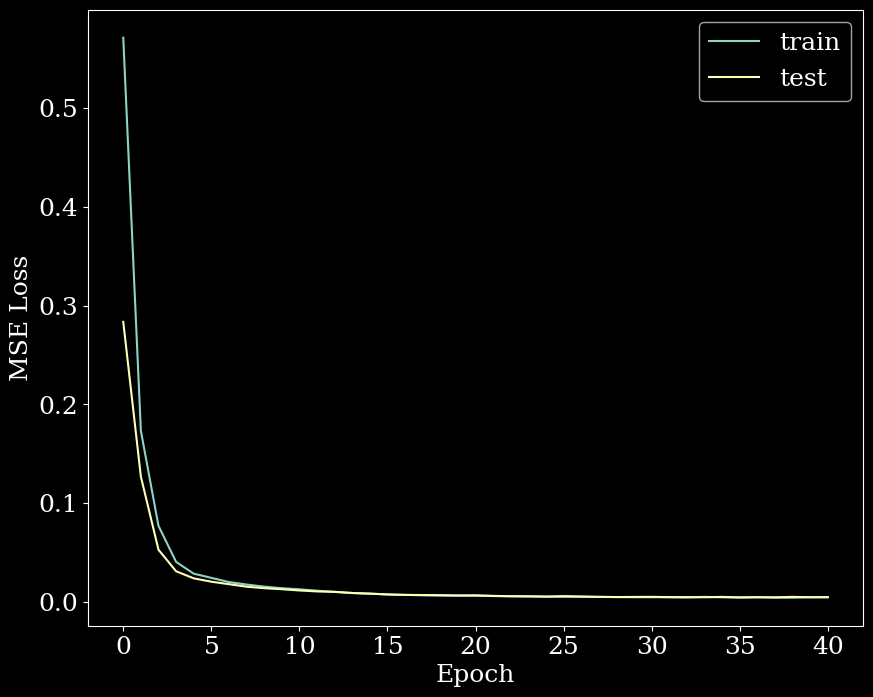

In [83]:
# loss function
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


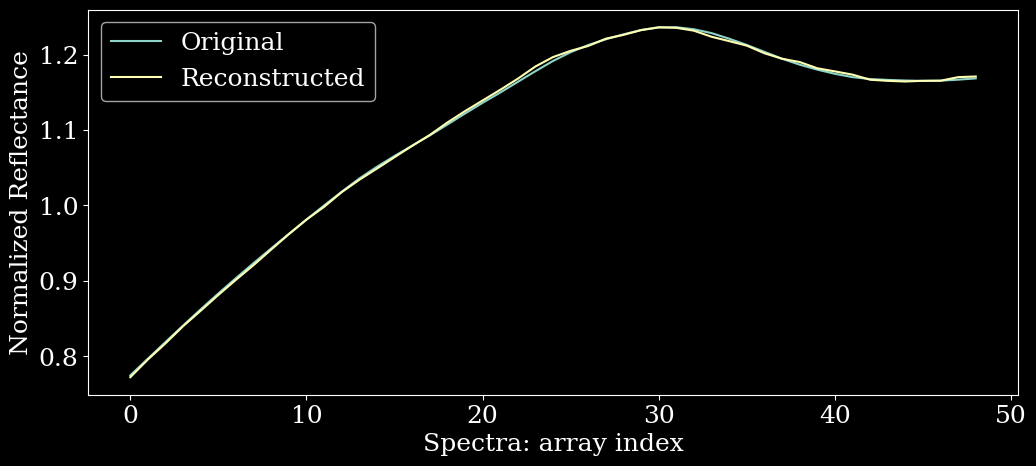

In [84]:
# reconstructing signals

index_val = 7

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]


# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")
plt.show()

In [85]:
# clustering autoencoder forming a datafram for GMMs

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


In [86]:
import sklearn.mixture
import tqdm

# Result dataframe contain the number of Gaussian components, the Bayesion Information
# Criterion (BIC) and the model itself
gmm_results_df = pd.DataFrame([], columns=["Nr_Comp", "BIC", "Model"])

# iterate through a number of "component guesses"
max_gauss = 15
for index, gauss_components in tqdm.tqdm(enumerate(np.arange(1, max_gauss+1, 1))):

    # Create and fit a temporary Gaussian Mixture Model
    temp_gmm = sklearn.mixture.GaussianMixture(n_components=gauss_components,
                                               covariance_type="full")
    temp_gmm.fit(X_encoded_scaled)

    # Store the number of components, the BIC and the model
    gmm_results_df.loc[index, "Nr_Comp"] = gauss_components
    gmm_results_df.loc[index, "BIC"] = temp_gmm.bic(X_encoded_scaled)
    gmm_results_df.loc[index, "Model"] = temp_gmm

15it [00:00, 24.91it/s]


(1.0, 15.0)

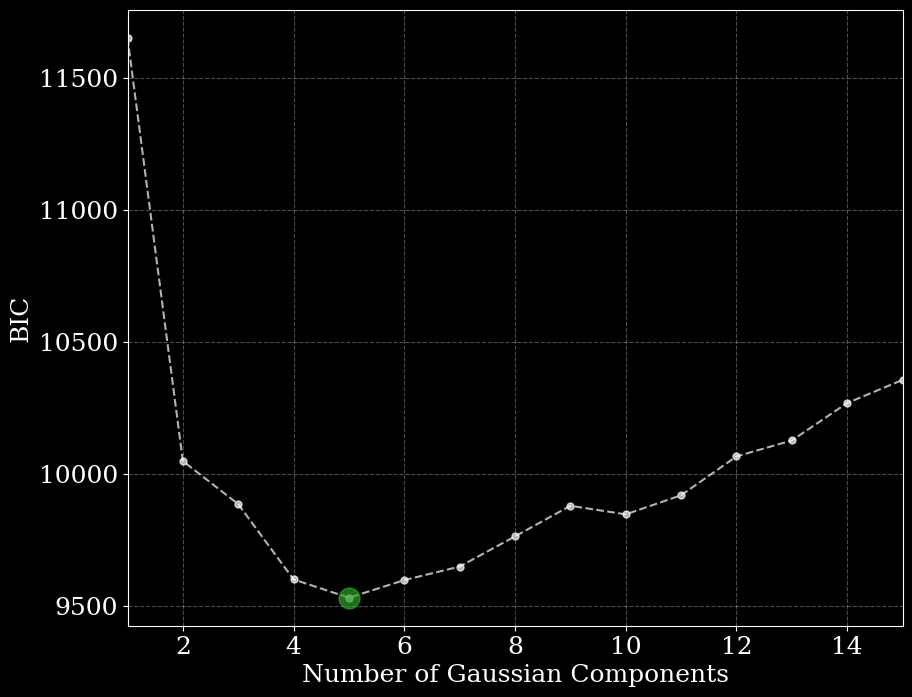

In [87]:
# Plotting the BIC vs. the number of components
plt.figure(figsize=(10, 8))

plt.plot(gmm_results_df["Nr_Comp"],
         gmm_results_df["BIC"],
         linestyle="dashed",
         marker="o",
         markersize=5,
         color="w",
         alpha=0.7)

# Color the minimum value
gmm_results_best = gmm_results_df.loc[gmm_results_df["BIC"] == gmm_results_df["BIC"].min()]
plt.plot(gmm_results_best["Nr_Comp"],
         gmm_results_best["BIC"],
         marker="o",
         markersize=15,
         color="tab:green",
         alpha=0.7)

plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(1, max_gauss)

In [88]:
# best GMMs
best_gmm = gmm_results_best["Model"].iloc[0]

# Create a new dataframe column that labels the spectra based on our GMM model:
encoded_df.loc[:, "GMM_Class"] = best_gmm.predict(encoded_df[encoder_space_cols].values)

encoded_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class
0,-1.286833,-2.316546,2.627618,-1.310704,2.206658,Other,A,3
1,-0.499928,-0.002432,0.247864,-0.087782,0.049476,S,S,1
2,-0.040271,0.002181,0.416649,-0.758205,0.704488,S,S,1
3,-0.335893,-0.413064,0.85028,-0.891808,0.641671,S,S,1
4,0.761569,0.429968,-1.11454,0.922033,-0.784364,C,C,4
...,...,...,...,...,...,...,...,...
1336,-0.261667,0.379683,-0.81276,1.007608,-1.035914,C,Ch,4
1337,0.818432,1.247387,-1.311082,1.06671,-1.018845,C,Ch,4
1338,0.46008,0.192673,-1.078742,1.133363,-0.893911,C,C,4
1339,0.838187,-0.424153,-1.406541,0.87563,-1.20866,C,B,0


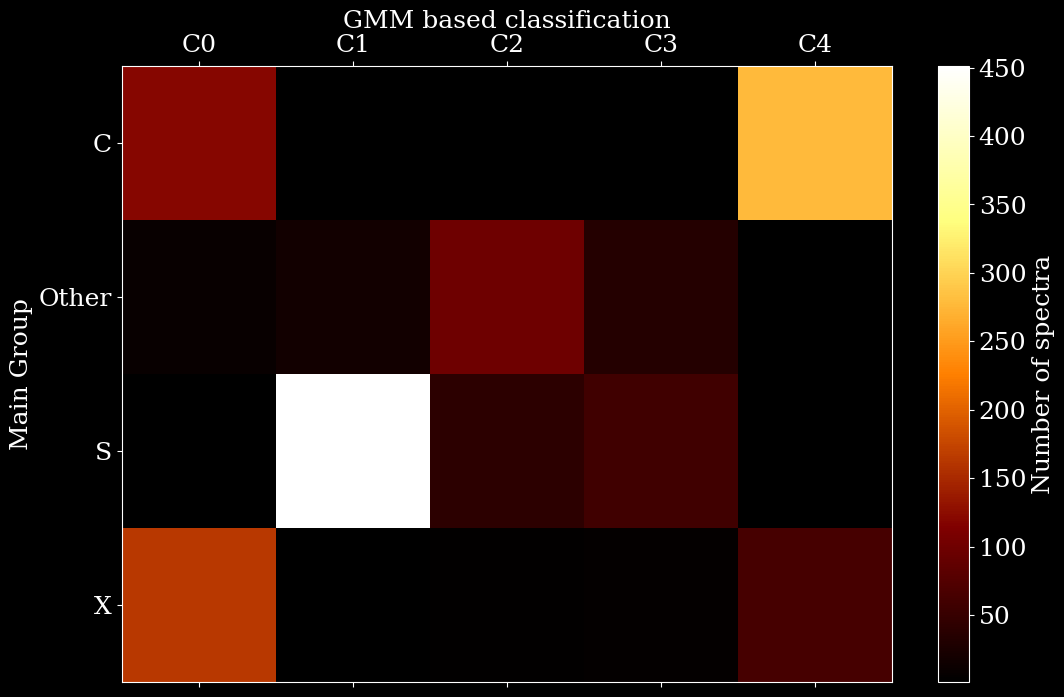

In [89]:
# gmm based confusion matrix

encoded_grouped_df = pd.crosstab(index=encoded_df["Main_Group"],
                                 columns=encoded_df["GMM_Class"],
                                 values=encoded_df["enc1"],
                                 aggfunc="count")

# Extract data, column and index names for plotting purposes
encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_gmm = [f"C{k}" for k in encoded_grouped_df.columns.values]

# Create a matrix-like plot of the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

ax.set_xticks(range(len(encoded_grouped_gmm)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_gmm)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("GMM based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')

In [90]:
# now checking the pval for a gaussian distribution or not

In [96]:
# check for corresponding GMM class
encoded_main_s_df = encoded_df.loc[encoded_df["Main_Group"] == "X"].copy()

encoded_main_s_df.groupby("GMM_Class").count()

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class
GMM_Class,,,,,,,
0,164,164,164,164,164,164,164
2,4,4,4,4,4,4,4
3,6,6,6,6,6,6,6
4,63,63,63,63,63,63,63


In [97]:
# probability of each laten vector
encoded_grouped_gmm_prob = [f"C{k}Prob" for k in encoded_grouped_df.columns.values]

encoded_main_s_df.loc[:, encoded_grouped_gmm_prob] = \
    best_gmm.predict_proba(encoded_main_s_df[encoder_space_cols].values)

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob
10,0.576762,-0.114403,-0.40005,0.297461,-0.999663,X,Xc,0,0.994165,1.361699e-05,0.000260,0.005550,0.000011
16,-0.484338,0.080879,-0.824308,1.461457,-0.551338,X,X,0,0.668045,8.103826e-08,0.010246,0.005725,0.315984
17,-0.444366,-0.241992,-0.043554,0.030044,-0.859472,X,Xe,0,0.983701,1.068277e-03,0.000632,0.014398,0.000200
20,0.233591,0.550179,-0.601114,0.784889,-0.308755,X,Xc,0,0.841467,1.137146e-04,0.010078,0.002294,0.146047
22,-0.208509,0.4369,-0.614436,0.728523,-0.642903,X,X,4,0.367313,1.353371e-04,0.003118,0.000494,0.628940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,-0.150609,0.161003,-0.098906,0.337869,-1.234272,X,X,0,0.997813,1.886400e-05,0.000218,0.001065,0.000886
1312,0.142541,0.341312,-0.786474,0.906686,-0.513785,X,X,4,0.242986,1.771167e-06,0.000698,0.000155,0.756160
1321,-0.403198,-0.087359,-0.934387,0.974188,-0.439104,X,X,0,0.959202,3.036616e-06,0.007962,0.001359,0.031474
1322,-1.621407,-0.811415,0.372967,0.854591,-0.620394,X,X,2,0.399786,2.262060e-05,0.567194,0.032794,0.000204


Text(0, 0.5, 'Number of spectra')

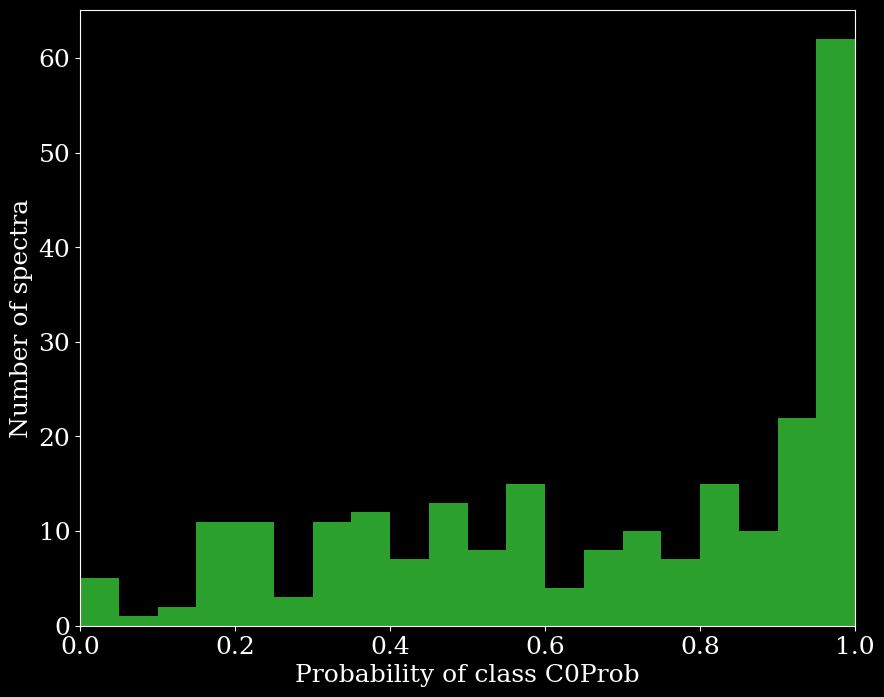

In [98]:
# histograms
gmm_cl = "C0Prob"

# Let's plot the probability distribution
plt.figure(figsize=(10, 8))

plt.hist(encoded_main_s_df[gmm_cl], bins=np.arange(0, 1.1, 0.05), color="tab:green")

plt.xlim(0, 1)

plt.xlabel(f"Probability of class {gmm_cl}")
plt.ylabel("Number of spectra")

In [99]:
# spectra most likely linked to gaussian with >= 0.95
encoded_main_s_df = encoded_main_s_df.loc[encoded_main_s_df[gmm_cl] >= 0.95]

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob
10,0.576762,-0.114403,-0.40005,0.297461,-0.999663,X,Xc,0,0.994165,1.361699e-05,0.000260,0.005550,1.147378e-05
17,-0.444366,-0.241992,-0.043554,0.030044,-0.859472,X,Xe,0,0.983701,1.068277e-03,0.000632,0.014398,2.001196e-04
29,-0.366785,0.432229,0.171719,0.240484,-1.620429,X,Xc,0,0.999511,6.317523e-08,0.000028,0.000435,2.654151e-05
35,-0.939247,-0.984742,0.251797,0.118006,-0.802842,X,Xe,0,0.983570,2.944403e-05,0.000277,0.016114,8.751388e-06
105,0.266412,0.118147,-0.952415,0.50501,-0.807577,X,Xe,0,0.992310,1.315482e-04,0.003395,0.001986,2.177659e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217,-0.103282,0.576648,-0.75832,0.609354,-0.69343,X,Xe,0,0.953301,9.505228e-04,0.010270,0.001480,3.399800e-02
1219,-0.001802,-0.26138,-0.650306,0.320653,-0.534202,X,X,0,0.973705,2.147237e-03,0.010377,0.011665,2.105256e-03
1253,0.42384,-0.596244,-0.349825,-0.013809,-1.279493,X,Xc,0,0.969711,3.719510e-06,0.000014,0.030272,9.145871e-11
1308,-0.150609,0.161003,-0.098906,0.337869,-1.234272,X,X,0,0.997813,1.886400e-05,0.000218,0.001065,8.859020e-04


In [100]:
# mutlivariate normality for distribution
import pingouin

encoded_main_s = np.array(encoded_main_s_df[encoder_space_cols].values, dtype="float64")
pingouin.multivariate_normality(encoded_main_s)

HZResults(hz=np.float64(1.0361962918025756), pval=np.float64(0.008876782129987456), normal=False)

In [30]:
# normal is False and the pval is really low meaning probability is low for a gaussian distribution